# 建模调参

In [4]:
#1 读取数据
import pandas as pd 
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

In [5]:
#通过调整数据类型，减少数据在内存中占用的空间
def reduce_mean_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum()
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min() 
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            
    end_mem = df.memory_usage().sum()
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
sample_feature = reduce_mean_usage(pd.read_csv('./data_for_tree.csv'))

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520303.00 MB
Decreased by 73.4%


In [7]:
continous_feature_names = [x for x in sample_feature.columns if x not in ['price', 'brand', 'model']]

# 线性回归 & 五折交叉验证 &模拟真实业务情况

In [8]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continous_feature_names + ['price']]

train_X = train[continous_feature_names]
train_Y = train['price']

In [9]:
# 线性回归
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_Y)

In [12]:
# 查看线性回归模型的截距(intercept)和权重(coef)
'intercept:' + str(model.intercept_)
sorted(dict(zip(continous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)


[('v_6', 3367064.341641892),
 ('v_8', 700675.5609398823),
 ('v_9', 170630.27723221408),
 ('v_7', 32322.661932028997),
 ('v_12', 20473.67079693847),
 ('v_3', 17868.07954148356),
 ('v_11', 11474.938996687828),
 ('v_13', 11261.764560010604),
 ('v_10', 2683.920090598847),
 ('gearbox', 881.8225039248246),
 ('fuelType', 363.90425072142494),
 ('bodyType', 189.6027101207286),
 ('city', 44.94975120522865),
 ('power', 28.55390161675519),
 ('brand_price_median', 0.5103728134078794),
 ('brand_price_std', 0.450363470926305),
 ('brand_amount', 0.14881120395066075),
 ('brand_price_max', 0.003191018670312298),
 ('SaleID', 5.355989919861131e-05),
 ('train', -1.1175870895385742e-08),
 ('seller', -2.7040368877351284e-07),
 ('offerType', -1.6549602150917053e-06),
 ('brand_price_sum', -2.1750068681876853e-05),
 ('name', -0.00029800127130892476),
 ('used_time', -0.002515894332847369),
 ('brand_price_average', -0.40490484510111163),
 ('brand_price_min', -2.2467753486889808),
 ('power_bin', -34.42064411728899

In [13]:
# 绘制曲线
from matplotlib import pyplot as plt
subsample_index = np.random.randint(low=0, high=len(train_Y), size=50)

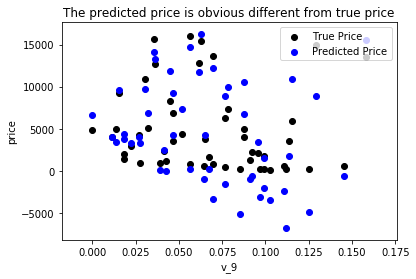

In [16]:
#绘制特征v_9的值与标签的散点图，图片发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大，且部分预测值出现了小于0的情况，说明我们的模型存在一些问题
plt.scatter(train_X['v_9'][subsample_index], train_Y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price', 'Predicted Price'], loc='upper right')
#print('The predicted price is obvious different from true price')
plt.title("The predicted price is obvious different from true price")
plt.show()

It is clear to see the price shows a typical exponential distribution


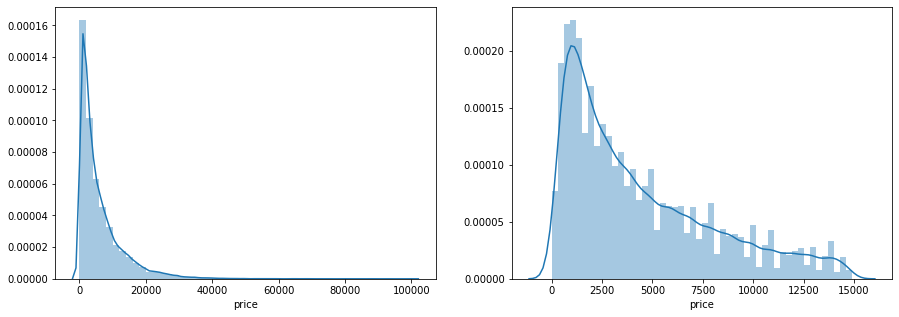

In [17]:
#通过作图我们发现数据的标签（price）呈现长尾分布，不利于我们的建模预测。原因是很多模型都假设数据误差项符合正态分布，而长尾分布的数据违背了这一假设。参考博客
# https://blog.csdn.net/Noob_daniel/article/details/76087829
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(train_Y)
plt.subplot(1, 2, 2)
sns.distplot(train_Y[train_Y < np.quantile(train_Y, 0.9)])

In [18]:
# 在这里我们对标签进行了 log(x + 1)变换，使标签贴近于正态分布
train_Y_ln = np.log(train_Y + 1)

The transformed price seems like normal distribution


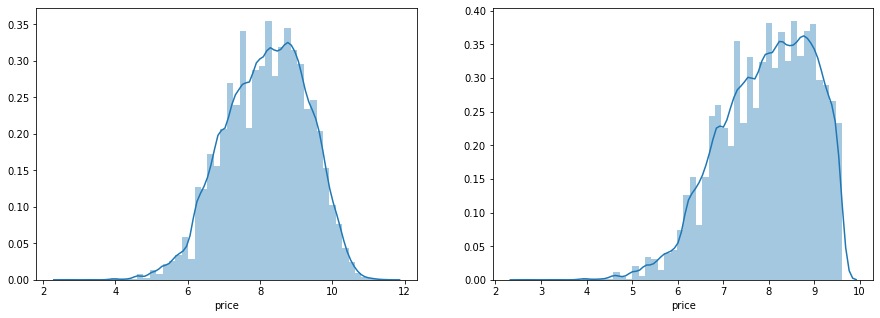

In [21]:
import seaborn as sns 
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_Y_ln)
plt.subplot(1,2,2)
sns.distplot(train_Y_ln[train_Y_ln < np.quantile(train_Y_ln, 0.9)])

In [24]:
model = model.fit(train_X, train_Y_ln)
print("intercept:" + str(model.intercept_))
sorted(dict(zip(continous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.750749465574437


[('v_9', 8.052409900567705),
 ('v_5', 5.7642365966527045),
 ('v_12', 1.6182081236777799),
 ('v_1', 1.479831058298397),
 ('v_11', 1.166901656359277),
 ('v_13', 0.9404711296031496),
 ('v_7', 0.7137273083564193),
 ('v_3', 0.6837875771076581),
 ('v_0', 0.008500518010062918),
 ('power_bin', 0.008497969302893872),
 ('gearbox', 0.007922377278328122),
 ('fuelType', 0.0066847697068285064),
 ('bodyType', 0.004523520092702897),
 ('power', 0.0007161894205356957),
 ('brand_price_min', 3.334351114743906e-05),
 ('brand_amount', 2.897879704277462e-06),
 ('brand_price_median', 1.2571172873034224e-06),
 ('brand_price_std', 6.659176363461215e-07),
 ('brand_price_max', 6.194956307516807e-07),
 ('brand_price_average', 5.999345965030207e-07),
 ('SaleID', 2.1194170039651405e-08),
 ('train', -2.2737367544323206e-13),
 ('seller', -9.629630426388758e-12),
 ('offerType', -3.8536285273949034e-11),
 ('brand_price_sum', -1.5126504215921632e-10),
 ('name', -7.015512588883622e-08),
 ('used_time', -4.122479372352487e-

The predicted price seems normal after np.log transforming


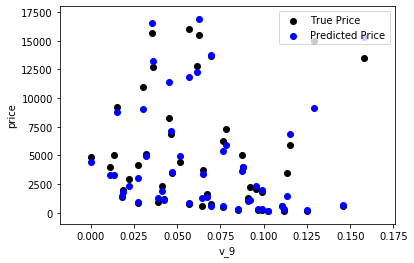

In [26]:
# 再次进行可视化，发现预测结果与真实值较为接近，且未出现异常状况
plt.scatter(train_X['v_9'][subsample_index], train_Y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

scores = cross_val_score(model, X=train_X, y=train_Y, verbose=1, cv=5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


In [30]:
#使用线性回归模型，对未处理标签的特征数据进行五折交叉验证
print("AVG: ", np.mean(scores))

AVG:  1.3658023920313986


In [31]:
#使用线性回归模型，对处理过标签的特征数据进行五折交叉验证
scores = cross_val_score(model, X=train_X, y=train_Y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


In [32]:
print("AVG: ", np.mean(scores))

AVG:  0.1932530183704742


In [33]:
scores = pd.DataFrame(scores.reshape(1, -1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


In [36]:
import datetime
sample_feature = sample_feature.reset_index(drop=True)
split_point = len(sample_feature) // 5 * 4

train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continous_feature_names]
val_y_ln = np.log(val['price'] + 1)

model = model.fit(train_X, train_y_ln)
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19577667270301014

In [37]:
# 绘制学习率曲线和验证曲线
from sklearn.model_selection import learning_curve, validation_curve
?learning_curve #查看函数的各种参数详细说明

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

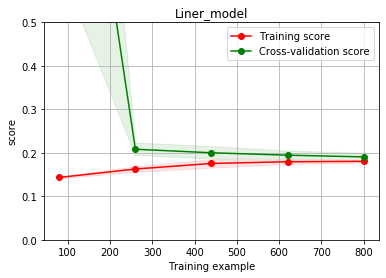

In [42]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_size=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training example')
    plt.ylabel('score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, 
                                                            scoring=make_scorer(mean_absolute_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid() #区域
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Cross-validation score")
    plt.legend(loc="best")
    return plt

plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)


In [43]:
# 多种模型对比
train = sample_feature[continous_feature_names + ['price']].dropna()

train_X = train[continous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

models = [LinearRegression(),
        Ridge(),
        Lasso()]

result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + 'is finished')

LinearRegressionis finished
Ridgeis finished
Lassois finished


In [46]:
# 三种方法的效果对比
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381893
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


intercept: 18.750749465615247


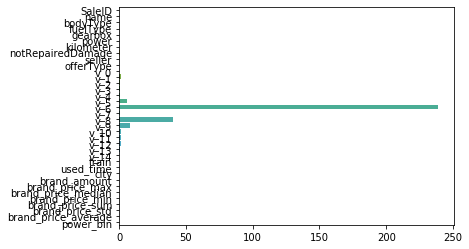

In [47]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept: ' + str(model.intercept_))
sns.barplot(abs(model.coef_), continous_feature_names)

intercept:4.671709786963157


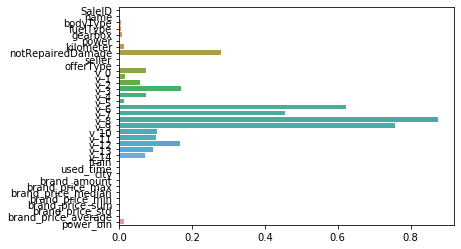

In [49]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continous_feature_names)

intercept:8.672182462666198


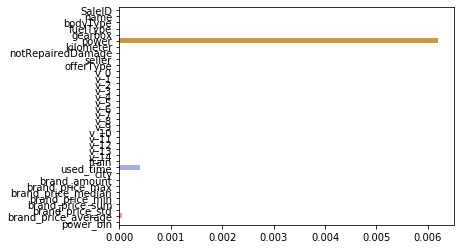

In [50]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continous_feature_names)

# 非线性模型

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

models = [LinearRegression(),
         DecisionTreeClassifier(),
         RandomForestClassifier(),
         GradientBoostingClassifier(),
         MLPRegressor(solver='lbfgs', max_iter=100),
         XGBRegressor(n_estimators=100, objective='reg:squarederror'),
         LGBMRegressor(n_estimators=100)]

result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + 'is finished')

LinearRegressionis finished
DecisionTreeClassifieris finished
RandomForestClassifieris finished
GradientBoostingClassifieris finished
MLPRegressoris finished
XGBRegressoris finished
LGBMRegressoris finished


In [57]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeClassifier,RandomForestClassifier,GradientBoostingClassifier,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.190792,NaN,NaN,NaN,244.797940,0.142378,0.141544
cv2,0.193758,NaN,NaN,NaN,534.366795,0.140922,0.145501
cv3,0.194132,NaN,NaN,NaN,315.150001,0.139393,0.143887
cv4,0.191825,NaN,NaN,NaN,400.190223,0.137492,0.142497
cv5,0.195758,NaN,NaN,NaN,190.179994,0.143733,0.144852
